# Length binned gradient boosting classifier

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
from __future__ import annotations

import h5py
import numpy as np
import pandas as pd
import multiprocessing as mp
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from joblib import parallel_backend

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Get ready to read the input data:

In [2]:
# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-1000_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

Let's also make a data structure to collect results for plotting as we go.

In [3]:
# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Make a dictionary of scoring functions to be used as metrics:

In [4]:
# Make evaluation metrics scorers
scoring_funcs = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

## 2. XGBoost XGBClassifier

### 2.1. Prepare data

In [5]:
def prep_data(features_df: pd.DataFrame, shuffle_control: bool) -> pd.DataFrame:
    '''Takes a dataframe of features, drops unnecessary or un-trainable features,
    cleans up missing data, shuffles and returns updated dataframe.'''

    # Next, get rid of un-trainable/unnecessary features
    feature_drops = [
        'Fragment length (words)',
        'Source',
        'String'
    ]

    features_df.drop(feature_drops, axis = 1, inplace = True)

    # Replace and remove string 'OOM' and 'NAN' values
    features_df.replace('NAN', np.nan, inplace = True)
    features_df.replace('OOM', np.nan, inplace = True)
    features_df.dropna(inplace = True)

    # Last, if this is a shuffle control run, randomize the order of the
    # data. This will break the correspondence between features and labels
    if shuffle_control == True: 
        features_df = features_df.sample(frac = 1).reset_index(drop = True)

    return features_df

### 2.2. Run cross-validation

In [6]:
def run_cross_validation(features: pd.DataFrame, labels: pd.Series, scoring_funcs: dict) -> dict:
    '''Does the cross-validation'''

    # Use threading backend for parallelism because we are running in a
    # daemonic worker process started by multiprocessing and thus can't 
    # use multiprocessing again to spawn more processes
    with parallel_backend('threading', n_jobs = 2):

        # Instantiate sklearn gradient boosting classifier
        model = XGBClassifier(random_state = 42)

        # Run cross-validation
        scores = cross_validate(
            model,
            features.to_numpy(),
            labels.to_numpy(),
            cv = 3,
            n_jobs = 2,
            scoring = scoring_funcs
        )

    return scores


### 2.x. Cross-validate on bin

In [7]:
def cross_validate_bin(
        features_df: pd.DataFrame, 
        labels: pd.Series,
        scoring_funcs: dict,
        worker_num: int, 
        bin_id: str,
        shuffle_control: bool
) -> tuple[str, dict]:
    
    '''Runs cross-validation on bin data with XGBClassifier'''

    # Clean up the features for training
    features = prep_data(features_df, shuffle_control)

    # Do the cross-validation training run
    results = run_cross_validation(features, labels, scoring_funcs)

    return bin_id, results

### 2.x. Put it all together

In [8]:
def cross_validate_bins(
        input_file: str,
        scoring_funcs: dict,
        parsed_results: dict,
        num_workers: int,
        shuffle_control: bool = False
) -> dict:

    '''Main function to parallelize cross-validation of XGBoost classifier
    over the data's length bins.'''

    # Get the bins from the hdf5 file's metadata
    data_lake = h5py.File(input_file, 'r')
    bins = dict(data_lake.attrs.items())
    data_lake.close()

    # Instantiate worker pool
    pool = mp.Pool(
        processes = num_workers,
        maxtasksperchild = 1
    )

    # Holder for returns from workers
    async_results = []

    # Open a connection to the hdf5 dataset via PyTables with Pandas
    data_lake = pd.HDFStore(input_file)

    # Loop on the bins
    for worker_num, bin_id in enumerate(bins.keys()):

        # Pull the training features for this bin
        bin_training_features_df = data_lake[f'training/{bin_id}/features']

        # Pull the training labels for this bin
        bin_training_labels = data_lake[f'training/{bin_id}/labels']

        async_results.append(
            pool.apply_async(cross_validate_bin,
                args = (
                    bin_training_features_df, 
                    bin_training_labels,
                    scoring_funcs,
                    worker_num,
                    bin_id,
                    shuffle_control
                )
            )
        )

    # Clean up
    pool.close()
    pool.join()

    # Get the results
    results = [async_result.get() for async_result in async_results]

    print()

    # Add the results
    for result in results:

        bin_id = result[0]
        scores = result[1]
        parsed_results = helper_funcs.add_cv_scores(parsed_results, scores, bin_id)

    data_lake.close()

    return parsed_results

### 2.x. Results

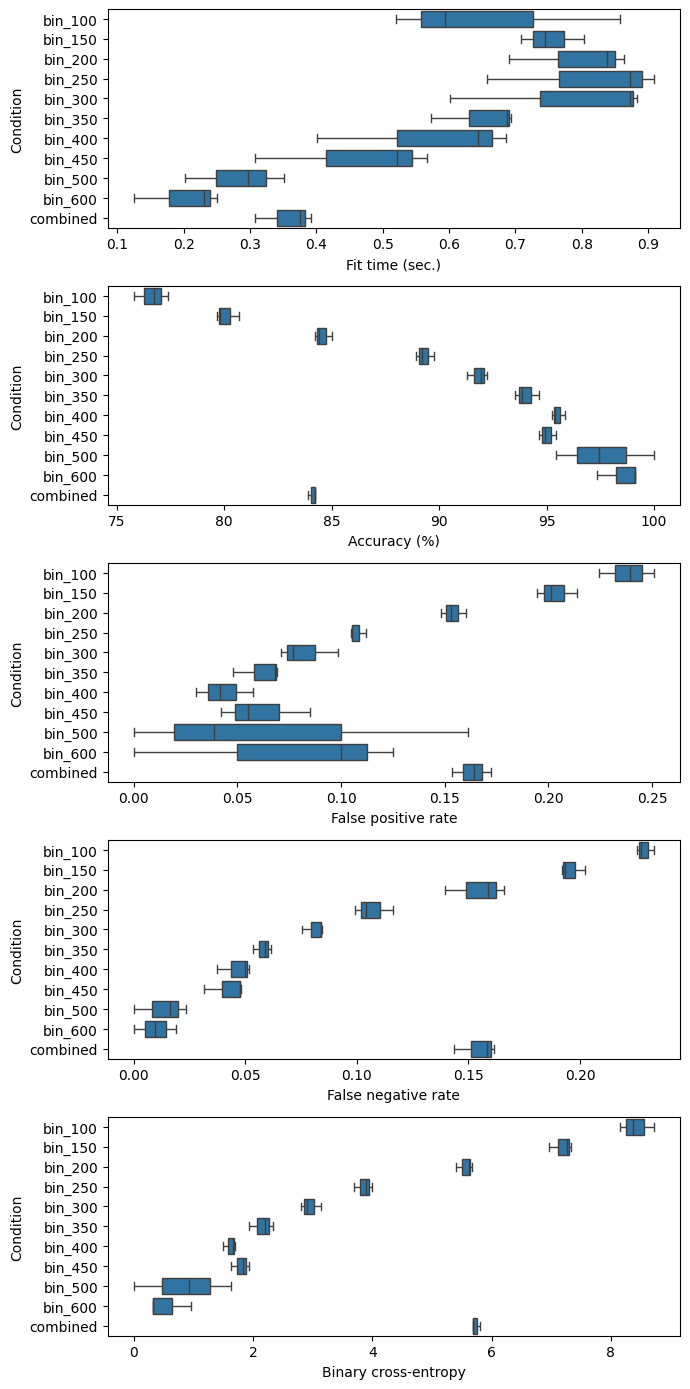

In [9]:
parsed_results = cross_validate_bins(input_file, scoring_funcs, parsed_results, 5)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

### 2.x. Results: shuffled control

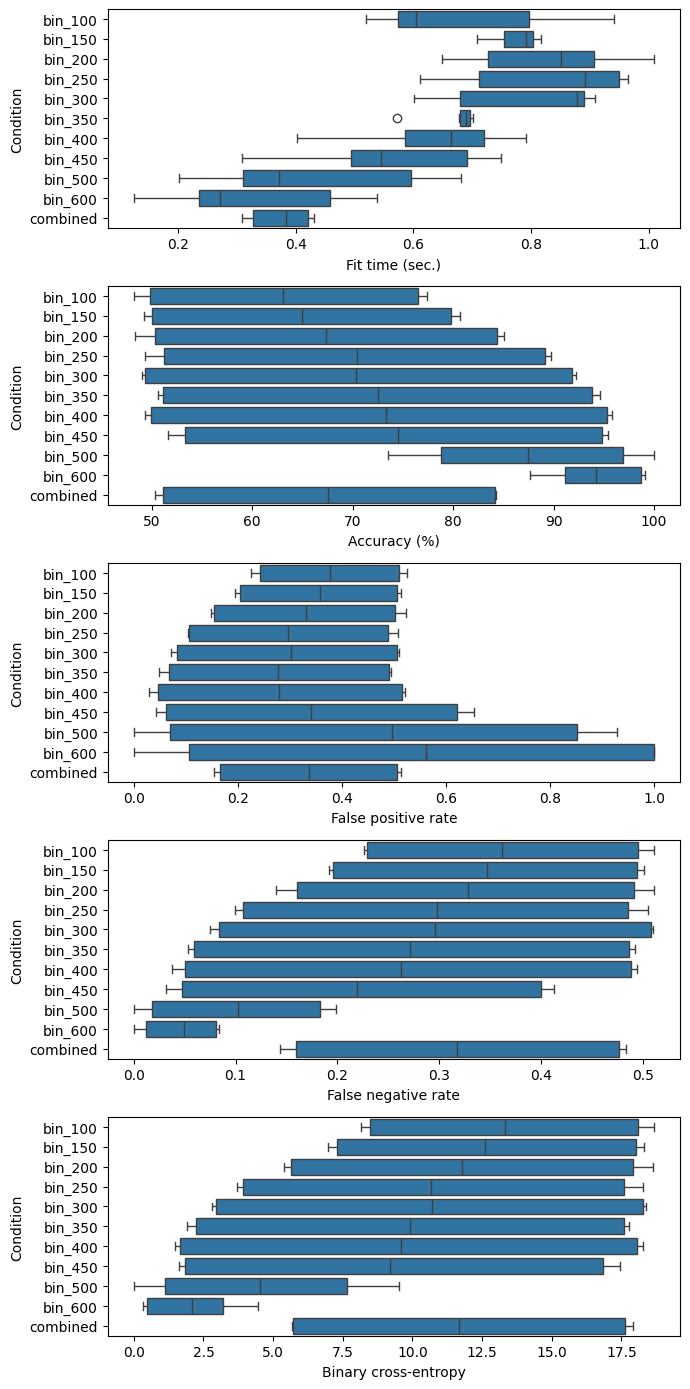

In [10]:
parsed_results = cross_validate_bins(input_file, scoring_funcs, parsed_results, 5, shuffle_control = True)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. We may be in trouble on short text fragments - we don't get to 90% accuracy until bin 250 which contains fragments between 151 and 250 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

I think that's it for tonight, more tomorrow. Already have some thoughts about how to deal with the overlapping bins and combining the outputs from the parallel classifiers...
